In [19]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt
import cv2
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import h5py
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab_Notebooks/'
path2 = '/content/drive/My Drive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Transform used to process training set and testing set data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# Create training set
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

# Create training loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

# Create testing set
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Create testing loaders
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# All possible digit classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Net class with the specified layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 64 * 64)
        x = self.fc1(x)
        return x

# Instantiate net class
net = Net()

In [4]:
# Set loss function
criterion = nn.CrossEntropyLoss()

# Instantiate SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [5]:
# Train over 3 epochs
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 2.294
[1,  1000] loss: 2.271
[1,  1500] loss: 2.161
Finished Training


In [6]:
# Save our net as mnist_net.pt.pth
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [7]:
def split_image(image):
  preprocessed_digits = []
  image = np.squeeze(image)
  grey = image.copy()
  thresh = grey.copy()
  contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
      x,y,w,h = cv2.boundingRect(c)

      cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)

      digit = thresh[y:y+h, x:x+w]
      
      resized_digit = cv2.resize(digit, (18,18))
      
      padded_digit = np.pad(resized_digit, ((7,7),(7,7)), "constant", constant_values=0)
      
      preprocessed_digits.append(padded_digit)

  digits = torch.from_numpy(np.array(preprocessed_digits, dtype='uint8'))
  return digits

In [21]:
# Rayan's Additions here!
class H5Dataset(torch.utils.data.Dataset):

  def __init__(self, h5File):
      super(H5Dataset, self).__init__()
      hf = h5py.File(h5File , 'r')
      self.train_label = np.array(hf['train_labels'])
      self.train_data = np.array(hf['train_dataset'])

  def __getitem__(self, index):
    return (torch.from_numpy(self.train_data), torch.from_numpy(self.train_label))

  def __len__(self):
      return self.train_label.shape[0]

In [25]:
train_dataset = H5Dataset(path2 + 'MNIST_synthetic.h5')
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle = True, num_workers=2)


dataiter = iter(trainloader)
images,labels = dataiter.next()

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

# END OF RAYAN'S ADDITIONS!

Accuracy of the network on the test images: 80 %


In [18]:
hf = h5py.File(path + 'MNIST_synthetic.h5', 'r')
print(hf.keys())

X_train = hf['train_dataset']
print(X_train.shape)

y_train = np.array(hf['train_labels'])
print(y_train.shape)

X_test = hf['test_dataset']
print(X_test.shape)

y_test = np.array([np.array([9,10,10,10,10]),np.array([0,1,7,3,10]),np.array([1,4,0,8,3]),np.array([0,10,10,10,10]),np.array([4,6,7,8,10]),np.array([0,10,10,10,10]),np.array([6,9,2,10,10]),np.array([3,7,10,10,10]),np.array([4,8,2,6,7]),np.array([9,6,6,0,10])])
print(y_test.shape)

OSError: ignored

In [ ]:
# Instantiate net class
net = Net()
net.load_state_dict(torch.load(PATH))


test_im = []
test_lab = []
for i in range(len(X_test)):
  for j in split_image(X_test[i]):
    test_im.append(j)
    #test_lab.append(y_test[i])
print(len(test_im))
a = torch.stack(test_im) 
print(a.shape)

42478
torch.Size([42478, 32, 32])


In [ ]:
a = torch.unsqueeze(a, 1)

# Pytorch train and test sets
test = torch.utils.data.TensorDataset(a)


# data loader
test_loader = torch.utils.data.DataLoader(test, batch_size = 32, shuffle = False, num_workers=2)

TypeError: ignored

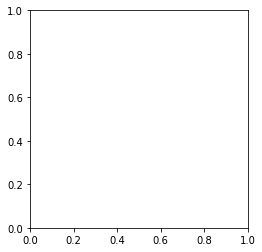

In [ ]:
dataiter2 = iter(test_loader)
lol = dataiter2.next()


outputs = net(lol)
_, predicted = torch.max(outputs, 1)

print("Prediction: " + predicted)